<div style='text-align: right;'>
Хабибуллин Р.А., Водопьян А.О <br>
2019-2021 <br>
версия 0.1  <br>
<br>
техническое описание для проекта <a href='https://github.com/unifloc/unifloc_vba'>Unifloc VBA</a>    <br>
использованы материалы из  <a href='https://github.com/unifloc/unifloc_py'>Unifloc_py</a>
</div>



# 1. PVT. Описание и примеры работы с pvt функциями

PVT - Pressure Volume Temperature 

PVT функции - набор функций реализующий расчет ключевые свойств воды, нефти и газа на основе различных корреляций. Задача текущего файла - описать основные расчетные функции для их последующего рефакторинга и переноса на python (если получится).

## Загрузка библиотек для построения графиков и проведения расчетов

Примеры используют функции Unifloc VBA из Excel надстройки UniflocVBA_7.xlam. А также примеры реализации функций на python 

In [3]:
"""
Импорт унифлока зависит от корректных путей к надстройке
Путь задается вручную в явном виде (так проще всего)
"""

unifloc_path = r'D:\unifloc\unifloc_vba'

import sys

unifloc_xlam = unifloc_path +r'\UniflocVBA_7.xlam'
print('Путь к надстройке Unifloc VBA -- '+ unifloc_xlam)

# добавим в путь поиска пакетов python папку где находится репозиторий Unifloc VBA
sys.path.insert(0, unifloc_path) 

# импортируем python_api для Unifloc VBA
import unifloc_vba_python_api.python_api as unifloc

# создаем объект имеющий доступ к расчетам Unifloc VBA
unf = unifloc.API(unifloc_xlam)
print('объект unf обеспечивает доступ к API Unifloc VBA')

Путь к надстройке Unifloc VBA -- D:\unifloc\unifloc_vba\UniflocVBA_7.xlam
объект unf обеспечивает доступ к API Unifloc VBA


In [4]:
# работа с внутренними функциями будет мимо unfloc python API
# поэтому надо быть готовым к ручному вызову функций
import xlwings as xw
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

In [5]:
# подключаемся к надстройки для вытаскивания функций вручную.
book = xw.Book(unifloc_xlam)

## Содержание

* [1.1. $P_b$ - давление насыщения](#1.1_давление_насыщения)
    * [1.1.1. Давление насыщения, корреляция Стендинга](#1.1.1_Давление_насыщения_корреляция_Стендинга)
    * [1.1.2. Давление насыщения, корреляция Валко Мак Кейна](#1.1.2_Давление_насыщения_корреляция_Valko_McCain)

## 1.1. $P_b$ - давление насыщения 
<a id="1.1_давление_насыщения"></a>

### 1.1.1 Давление насыщения, корреляция Стендинга
<a id="1.1.1_Давление_насыщения_корреляция_Стендинга"></a>

Корреляция Стендинга для оценки давления насыщения нефти газом. 

$$ P_b =  0.5197  \left( \frac{R_{sb}}{\gamma_g}\right)^{0.83} 10 ^{y_g} \tag{1.1.1.1}$$

где

$P_b$ - давление насыщения, $МПа$ 

$R_{sb}$ - газосодержание при давлении насыщения, $м^3/м^3 $

$\gamma_g$ - относительная плотность газа, безразмерная величина  

$y_g$ - мольная доля газа, $ y_g = 1.225 +0.00164 T - \frac{ 1.769}{\gamma_o}$

$\gamma_o$ - относительная плотность нефти, безразмерная величина  

$ T $ - температура, $ ^{\circ}\mathrm{K}$

Корреляции Standing базируются на 105 экспериментально определенных давлениях насыщения нефтяных систем Калифорнии. Диапазоны значений основных свойств, использованных для разработки данной корреляции, приведены в таблице ниже. 

| <p align="left"> Параметр  | Диапазон |
| :--- | :--- |
| <p align="left"> давление насыщения,$P_b$ , $ МПа $  | 0.896…48.263  |
| <p align="left"> температура, $^{\circ}\mathrm{K} $ | 310…400 |
| <p align="left"> газосодержание при давлении насыщения, $R_{sb}$ , $м^3/м^3 $ | 3.6…254 |
| <p align="left"> относительная плотность нефти по воде, $\gamma_o$ | 0.725…0.956  |
| <p align="left"> относительная плотность газа, $\gamma_g$  | 0.59…0.95  |


 
ref "A Pressure-Volume-Temperature Correlation for Mixtures of California Oil and Gases", M.B. Standing, Drill. & Prod. Prac., API, 1947.

In [6]:
# реализация Unifloc VBA
def unf_pb_Standing_MPaa_vba(rsb_m3m3, gamma_oil=0.86, gamma_gas=0.6, t_K=350):
    f_unf_pvt_pb_Standing_MPa = np.vectorize( book.macro("unf_pvt_pb_Standing_MPa") )
    return f_unf_pvt_pb_Standing_MPa(rsb_m3m3, gamma_gas, t_K, gamma_oil)

In [7]:
# реализация python для neftpy
def unf_pb_Standing_MPaa(rsb_m3m3, gamma_oil=0.86, gamma_gas=0.6, t_K=350):
    """
    bubble point pressure calculation according to Standing (1947) correlation

    :param rsb_m3m3: solution ration at bubble point, must be given, m3/m3
    :param gamma_oil: specific oil density (by water)
    :param gamma_gas: specific gas density (by air)
    :param t_K: temperature, K
    :return: bubble point pressure abs in MPa

    ref1 "A Pressure-Volume-Temperature Correlation for Mixtures of California Oil and Gases",
    M.B. Standing, Drill. & Prod. Prac., API, 1947.

    ref2  "Стандарт компании Юкос. Физические свойства нефти. Методы расчета." Афанасьев В.Ю., Хасанов М.М. и др. 2002 г
    """

    min_rsb = 1.8
    rsb_old = np.copy(rsb_m3m3)
    rsb_m3m3 = np.where(rsb_m3m3 < min_rsb, min_rsb, rsb_m3m3)
    yg = 1.225 + 0.001648 * t_K - 1.769 / gamma_oil         # gas molar fraction
    pb_MPaa = 0.5197 * (rsb_m3m3 / gamma_gas) ** 0.83 * 10 ** yg
    # for low rsb values, we set the asymptotics Pb = 1 atma at Rsb = 0
    # for large rsb values do not correct what the correlation gives
    return np.where(rsb_old < min_rsb, 
                                      (pb_MPaa - 0.1013) * rsb_old / min_rsb + 0.1013, 
                                      pb_MPaa
                    )


In [8]:
# проверка работоспособности расчетных функций vba и python
print(unf_pb_Standing_MPaa(100.))
print(unf_pb_Standing_MPaa_vba(100.))

20.170210695316566
20.170210695316566


#### Построение графиков зависимости давления насыщения $P_b$ от влияющих параметров и сравнение двух реализаций на VBA и python

Графики строятся дважды, при корректной реализации кода python (делался позже чем vba) - графики должны совпасть.

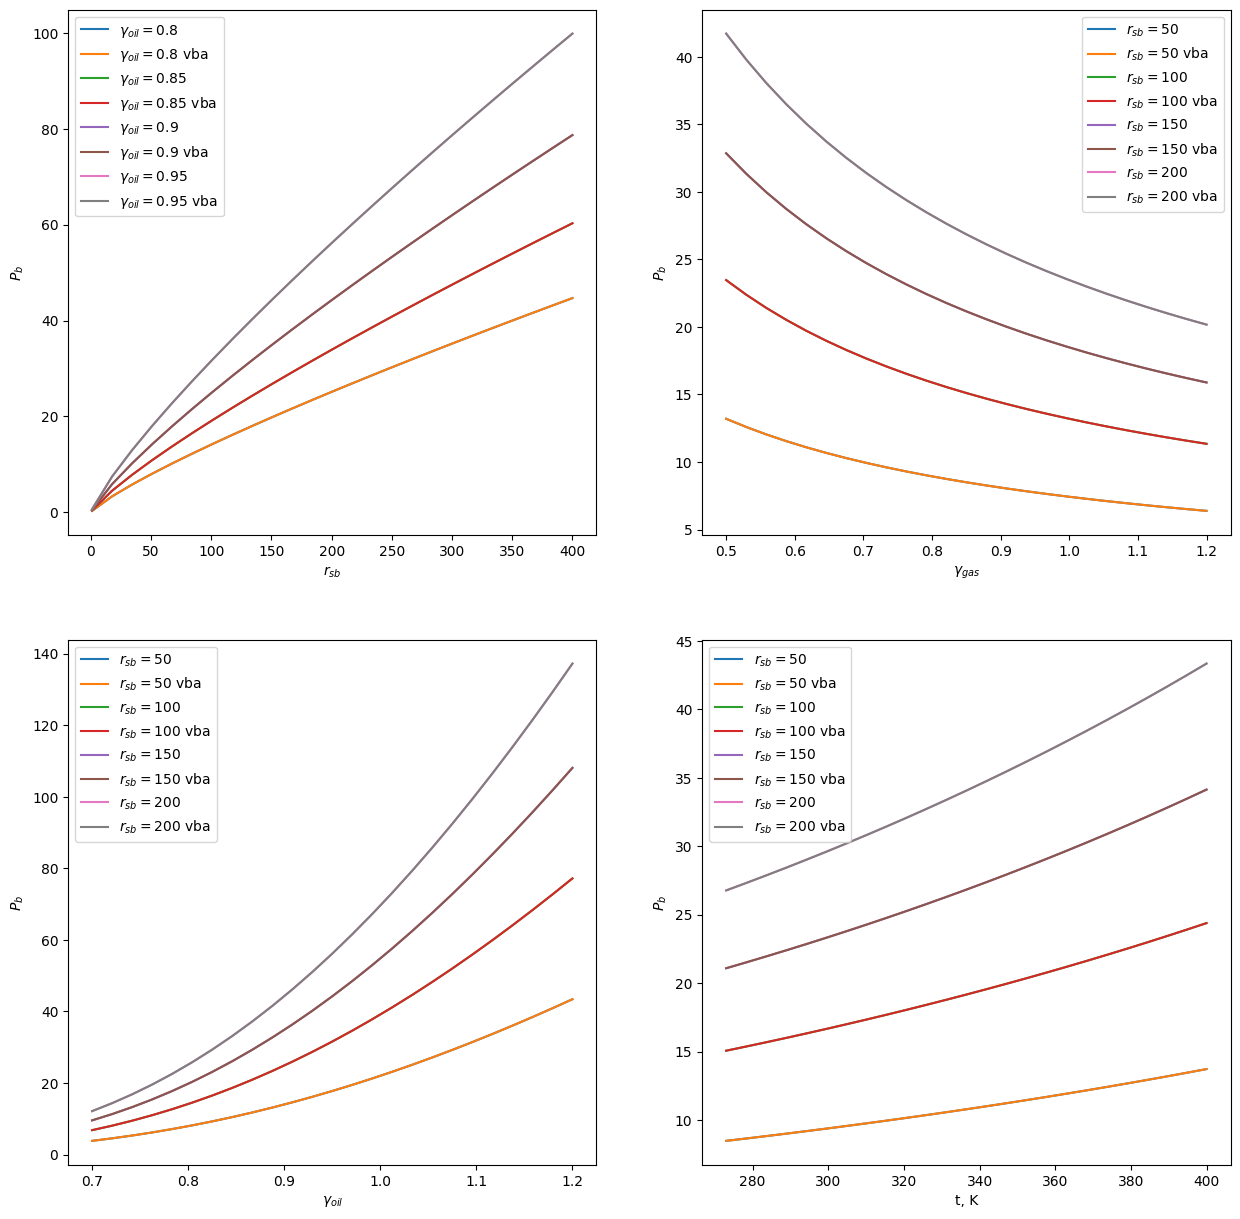

In [9]:
rsb_m3m3_arr = np.linspace(1,400,25)
gamma_gas_arr = np.linspace(0.5, 1.2, 25)
gamma_oil_arr = np.linspace(0.7, 1.2, 25)
t_K_arr = np.linspace(273, 400, 25)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))

for go in (0.8, 0.85, 0.9, 0.95):
    ax1.plot(rsb_m3m3_arr, unf_pb_Standing_MPaa(rsb_m3m3_arr, gamma_oil = go), label =f'$\gamma_{{oil}}={go}$')
    ax1.plot(rsb_m3m3_arr, unf_pb_Standing_MPaa_vba(rsb_m3m3_arr, gamma_oil = go), label =f'$\gamma_{{oil}}={go}$ vba')
ax1.set_xlabel('$r_{sb}$')
ax1.set_ylabel('$P_b$')
ax1.legend()

for rsb in (50, 100, 150, 200):
    ax2.plot(gamma_gas_arr, unf_pb_Standing_MPaa(rsb_m3m3=rsb, gamma_gas=gamma_gas_arr), label =f'$r_{{sb}}={rsb}$')
    ax2.plot(gamma_gas_arr, unf_pb_Standing_MPaa_vba(rsb_m3m3=rsb, gamma_gas=gamma_gas_arr), label =f'$r_{{sb}}={rsb}$ vba')
ax2.set_xlabel('$\gamma_{gas}$')
ax2.set_ylabel('$P_b$')
ax2.legend()

for rsb in (50, 100, 150, 200):
    ax3.plot(gamma_oil_arr, unf_pb_Standing_MPaa(rsb_m3m3=rsb, gamma_oil=gamma_oil_arr), label =f'$r_{{sb}}={rsb}$')
    ax3.plot(gamma_oil_arr, unf_pb_Standing_MPaa_vba(rsb_m3m3=rsb, gamma_oil=gamma_oil_arr), label =f'$r_{{sb}}={rsb}$ vba')
ax3.set_xlabel('$\gamma_{oil}$')
ax3.set_ylabel('$P_b$')
ax3.legend()

for rsb in (50, 100, 150, 200):
    ax4.plot(t_K_arr, unf_pb_Standing_MPaa(rsb_m3m3=rsb, t_K=t_K_arr), label =f'$r_{{sb}}={rsb}$')
    ax4.plot(t_K_arr, unf_pb_Standing_MPaa_vba(rsb_m3m3=rsb, t_K=t_K_arr), label =f'$r_{{sb}}={rsb}$ vba')
ax4.set_xlabel('t, K')
ax4.set_ylabel('$P_b$')
ax4.legend()

plt.show()

В реализованной версии кода использована коррекция значений давления насыщения при низких значениях газосодержания при давлении насыщения для обеспечения выхода на значение $P_b = 1$ при $R{sb} = 0$. Коррекция для малых значений газосодержания иллюстрируется на графике построенном ниже.


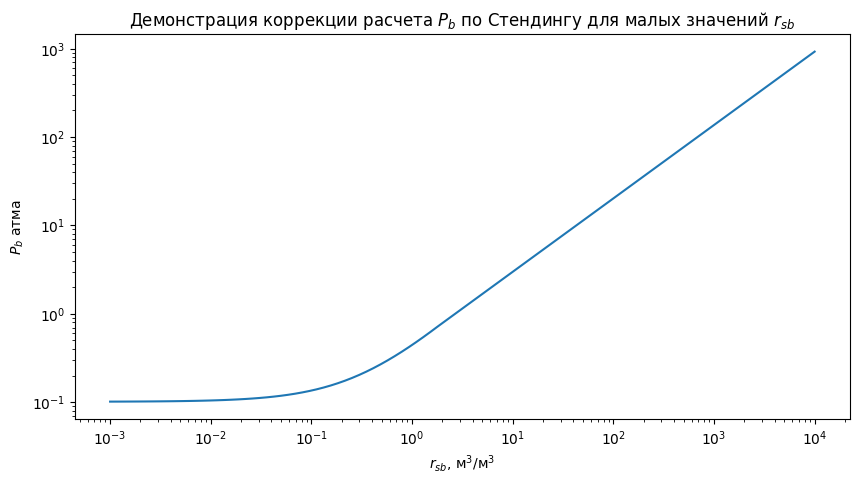

In [11]:
rsb_m3m3_arr = np.logspace(-3,4,100)

fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(rsb_m3m3_arr, unf_pb_Standing_MPaa(rsb_m3m3_arr))
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('$r_{sb}$, м$^3$/м$^3$')
ax1.set_ylabel('$P_b$ атма')
ax1.set_title('Демонстрация коррекции расчета $P_b$ по Стендингу для малых значений $r_{sb}$')
plt.show()

### 1.1.2 Давление насыщения, корреляция Valko McCain
<a id="1.1.2_Давление_насыщения_корреляция_Valko_McCain"></a>

Корреляция Valco McCain (2003) для оценки давления насыщения нефти газом разработана на основе банка данных нефтей со всего мира. На рисунке показаны источники данных, которые были использованы авторами для настройки корреляции.  

<img  src="pics/McCain_corr_sources.png" width="400"  >


Диапазоны значений основных свойств (1745 значений), использованных для разработки данной корреляции, приведены в таблице ниже. 

| <p align="left"> Параметр  | Мин|Среднее|Макс|
| :--- | :---: |:---:|:---:|
| <p align="left"> давление насыщения,$P_b$ , $ МПа $  | 0.55  |15.0|45.5|
| <p align="left"> температура, $^{\circ}\mathrm{С} $ | 15 |85|172|
| <p align="left"> газосодержание при давлении насыщения, $R_{sb}$ , $м^3/м^3 $ | 2 |104|395|
| <p align="left"> относительная плотность нефти по воде, $\gamma_o$ | 0.724  |0.846|1.02|
| <p align="left"> относительная плотность газа на сепараторе, $\gamma_g$  | 0.555  |0.838|1.685|
    
По результатам сравнений с замеренными значениями абсолютная значение средней относительной ошибки (AARE) для корреляции составляет около 11%. Авторы отмечают, что полученная точность соответствует точности замеров использованных для построения корреляции и для построения более точных зависимостей потребуется сбор новых данных с повышенной точностью.

$$
ln P_b = 7.475 + 0.713 z + 0.0075 z^2
$$
где 

$$
z = z_1+z_2+z_3+z_4
$$
$$
z_1 = -5.48 - 0.0375\cdot ln R_{sb}+0.281\cdot (ln R_{sb})^2 - 0.0206\cdot (ln R_{sb})^3
$$
$$
z_2 = 1.27 - 0.0449\cdot API +4.36 \cdot 10^{-4} API^2 -4.76 \cdot 10^{-6} API^3
$$
$$
z_3 = 4.51 - 10.84 \cdot \gamma_{gSP} +8.39\cdot \gamma_{gSP}^2 -2.34\cdot \gamma_{gSP}^3
$$
$$
z_4 = -0.7835 + 6.23 \cdot 10^{-3} \cdot T_R - 1.22 \cdot 10^{-5} \cdot T_R^2+ 1.03 \cdot 10^{-8} \cdot T_R^3
$$

где

* $p_b$ - давление насыщения, $psia$
* $R_{sb}$ - газосодержание при давлении насыщения, ${scf}/{STB}$
* $\gamma_{gSP}$ - удельная плотность газа, отобранного на сепараторе, безразмерная величина
* $T_R$ - пластовая температура, $F$


ref Reservoir oil bubblepoint pressures revisited; solution gas-oil ratios and surface gas specific gravities. P.P.Valko, W.D.McCain Jr. Journal of petroleum science and engineering 37(2003) 153-169


#### Пребразование единиц измерения для корреляции Валко Маккейна

In [12]:
# объявления переменных необходимых для преобразования единиц в вырожении
rsb_scfSTB, rsb_m3m3 = sp.symbols('R_sb[scfSTB] R_sb[m3m3]')
API, gamma_o = sp.symbols('API gamma_o')
gamma_gSP = sp.symbols('gamma_gSP')
T_RF,T_RK = sp.symbols('T_R[F] T_R[K]')
z,z1,z2,z3,z4 = sp.symbols('z,z1,z2,z3,z4')
p_bpsia, p_bMPaa = sp.symbols('p_b[psia],p_b[MPaa]')

In [13]:
# определение алгоритма расчета в американских промысловых единицах
eq1 = sp.Eq(z,z1+z2+z3+z4)
eq2 = sp.Eq(z1,  -5.48 - 0.03758 * sp.ln(rsb_scfSTB)+ 0.281*  sp.ln(rsb_scfSTB)**2 - 0.0206* sp.ln(rsb_scfSTB)**3)
eq3 = sp.Eq(z2,  1.27 - 0.0449* API +4.36 * 10**-4 *API**2 -4.76 * 10**-6 *API**3)
eq4 = sp.Eq(z3,  4.51- 10.84 *gamma_gSP +8.39*gamma_gSP**2 -2.34*gamma_gSP**3 )
eq5 = sp.Eq(z4,  -0.7835 + 6.23 * 10**-3 * T_RF - 1.22 * 10**-5 * T_RF**2+ 1.03 * 10**-8 * T_RF**3)
eq6 =sp.Eq(sp.ln(p_bpsia),(7.475 + 0.713 * z + 0.0075 * z**2))
# покажем выражения в печатном виде
display(eq6)
display(eq1)
display(eq2)
display(eq3)
display(eq4)
display(eq5)

Eq(log(p_b[psia]), 0.0075*z**2 + 0.713*z + 7.475)

Eq(z, z1 + z2 + z3 + z4)

Eq(z1, -0.0206*log(R_sb[scfSTB])**3 + 0.281*log(R_sb[scfSTB])**2 - 0.03758*log(R_sb[scfSTB]) - 5.48)

Eq(z2, -4.76e-6*API**3 + 0.000436*API**2 - 0.0449*API + 1.27)

Eq(z3, -2.34*gamma_gSP**3 + 8.39*gamma_gSP**2 - 10.84*gamma_gSP + 4.51)

Eq(z4, 1.03e-8*T_R[F]**3 - 1.22e-5*T_R[F]**2 + 0.00623*T_R[F] - 0.7835)

In [14]:
# выражения для преобразования единиц измерения из американских промысловых в практические метрические
scfSTB_to_m3m3 = rsb_m3m3/0.178107606679035
API_to_gamma_o = 141.5/gamma_o-131.5
F_to_K = T_RK*9/5-459.67
psi_to_MPa = p_bMPaa * 14.6959 * 10.1325
# покажем выражения в печатном виде
display(sp.Eq(rsb_scfSTB , scfSTB_to_m3m3))
display(sp.Eq(API,API_to_gamma_o))
display(sp.Eq(T_RF,F_to_K))
display(sp.Eq(p_bpsia,psi_to_MPa))

Eq(R_sb[scfSTB], 5.61458333333334*R_sb[m3m3])

Eq(API, -131.5 + 141.5/gamma_o)

Eq(T_R[F], 9*T_R[K]/5 - 459.67)

Eq(p_b[psia], 148.90620675*p_b[MPaa])

In [15]:
# преобразование алгоритма в метрические единицы с использованием символьных вычислений
eq2_m = sp.simplify(eq2.subs(rsb_scfSTB,scfSTB_to_m3m3))
eq3_m = sp.simplify(eq3.subs(API,API_to_gamma_o))
eq5_m = sp.simplify(eq5.subs(T_RF,F_to_K))
eq6_m = eq6.subs(p_bpsia, psi_to_MPa)
eq8 = sp.solve(eq6_m,p_bMPaa)
eq9 = sp.Eq(p_bMPaa, eq8[0])
# вывод результатов преобразований
display(eq9)
display(eq1)
display(eq2_m)
display(eq3_m)
display(eq4)
display(eq5_m)

Eq(p_b[MPaa], 11.8423652490673*exp(0.0075*z**2 + 0.713*z))

Eq(z, z1 + z2 + z3 + z4)

Eq(z1, -0.0206*log(R_sb[m3m3])**3 + 0.174372295950536*log(R_sb[m3m3])**2 + 0.748104504934282*log(R_sb[m3m3]) - 4.81413889469569)

Eq(z2, 25.537681965 - 57.519938195/gamma_o + 46.327882495/gamma_o**2 - 13.485786265/gamma_o**3)

Eq(z3, -2.34*gamma_gSP**3 + 8.39*gamma_gSP**2 - 10.84*gamma_gSP + 4.51)

Eq(z4, 6.00696e-8*T_R[K]**3 - 8.554832172e-5*T_R[K]**2 + 0.043155018225018*T_R[K] - 7.22546617091445)

полученные выражения можно использовать для построения функции расчета без необходимости конвертации единиц измерения внутри функции

#### Различные реализации расчета 

In [16]:
# реализация Unifloc VBA
def unf_pb_Valko_MPaa_vba(rsb_m3m3, gamma_oil=0.86, gamma_gas=0.6, t_K=350):
    f_unf_pb_Valko_MPaa_vba = np.vectorize( book.macro("unf_pvt_pb_Valko_McCain_MPa") )
    return f_unf_pb_Valko_MPaa_vba(rsb_m3m3, gamma_gas, t_K, gamma_oil)